# Inteligência Artificial - Trabalho Nº2

### Temática 4: Aprendizagem Supervisionada – Regressão - European Soccer Database

## Autores:

* João Brandão - up201705573@fe.up.pt
* João Martins - up201605373@fe.up.pt
* José Martins - up201605497@fe.up.pt

Feup 2019/2020

## Resumo

Este projeto foi desenvolvido no âmbito da unidade curricular de Inteligência Artificial da Faculdade de Engenharia da Universidade do Porto e tem como objetivo usar aprendizagem computacional de forma a construir modelos de regressão. Para tal, foram utilizados algoritmos de aprendizagem supervisionada e um dado dataset, o European Soccer Database. Este dataset conta com mais de 26 mil jogos e aproximadamente 11 mil jogadores.
O projeto foi concluído com sucesso, sendo que todo o seu desenvolvimento, resultados obtidos e conclusões, serão expostos neste notebook.

## 1. Introdução

O projeto realizado consiste na criação de um agente inteligente capaz de prever as “odds” de jogos de futebol. Para isso, inicialmente, foi realizada uma análise exploratória dos dados disponíveis sobre os jogadores e encontros realizados. Além disso, implementamos diferentes algoritmos de aprendizagem e posteriormente comparamos os seus desempenhos e tempo despendido para efetuar os testes.
Posto isto, o agente inteligente criado poderá ser utilizado para prever as “odds” da equipa da casa, da equipa visitante e de empate em qualquer jogo de futebol.

## 2. Descrição do problema

Foi utilizado o dataset [European Soccer Database](https://www.kaggle.com/hugomathien/soccer).
Este dataset conta com cerca de 26 mil jogos de 11 diferentes ligas de futebol diferentes entre 2008 e 2016 e com cerca de 11 mil jogadores com ratings retirados do videojogo FIFA.

## 3. Abordagem

Inicialmente foi criado um novo dataset que possui informação sobre milhares de jogos de futebol, incluindo:
* O rating médio do 11 inicial de cada equipa, sendo o rating de cada jogador o mais recente à data do jogo, fornecido pelo videojogo FIFA.
* A forma de cada equipa, tendo em conta os últimos 5 jogos.
* A forma da equipa da casa em casa, tendo em conta os últimos 5 jogos em casa.
* A forma da equipa visitante em jogos fora, tendo em conta os últimos jogos fora.
* As odds da equipa da casa, da equipa visitante e de empate, fornecidas pelo Bet365

Após a criação deste dataset, construímos modelos de regressão que usam os dados indicados pelos primeiros 4 pontos para obter os dados indicados pelo 5º ponto, as odds do jogo.

### Imports 

Começamos por fazer os imports necessários para a realização este projeto

In [54]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import time
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns', None)
%matplotlib inline

### Database

De seguida carregamos a database e criamos duas funções para recolher dados de uma tabela como um dataframe

In [2]:
db_location = "../Data/soccer/database.sqlite"

# Create dictionary
def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d


# Get dataframe with the given table
def get_table_as_pd_dataframe(table_name):
    query = 'SELECT * FROM ' + table_name + ';'

    con = sqlite3.connect(db_location)
    con.row_factory = dict_factory
    cur = con.cursor()

    cur.execute(query)
    table = cur.fetchall()

    con.close()

    return pd.DataFrame(table)

### Informação dos jogos
Começamos por criar um dataframe com a tabela Match, que contém toda a informação sobre os jogos realizados.

In [3]:
# Get matches from database
matches = get_table_as_pd_dataframe('Match')

matches

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Depois atualizamos o dataframe, de forma a ter apenas as colunas necessárias para o desenvolvimento do projeto. Além disso, retiramos as linhas com valores nulos e organizamos os dados por época e data.

In [4]:
# Set dataframe with only the important columns
matches = matches[["id",
                    "season",
                    "date",
                    "home_team_api_id",
                    "away_team_api_id",
                    "home_team_goal",
                    "away_team_goal",
                    "home_player_1",
                    "home_player_2",
                    "home_player_3",
                    "home_player_4",
                    "home_player_5",
                    "home_player_6",
                    "home_player_7",
                    "home_player_8",
                    "home_player_9",
                    "home_player_10",
                    "home_player_11",
                    "away_player_1",
                    "away_player_2",
                    "away_player_3",
                    "away_player_4",
                    "away_player_5",
                    "away_player_6",
                    "away_player_7",
                    "away_player_8",
                    "away_player_9",
                    "away_player_10",
                    "away_player_11",
                    "B365H",
                    "B365D",
                    "B365A"]]

# Drop rows with null values
matches = matches.dropna()

# Sort by season and date
matches = matches.sort_values(by=['season', 'date'])

matches

,id,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
4769,4770,2008/2009,2008-08-09 00:00:00,9827,7819,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,1.57,3.60,6.50
4770,4771,2008/2009,2008-08-09 00:00:00,9746,9831,1,0,41186.0,71607.0,38111.0,46447.0,103470.0,46651.0,46647.0,109590.0,46656.0,26405.0,41146.0,33617.0,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0,2.30,3.00,3.40
4773,4774,2008/2009,2008-08-09 00:00:00,9829,9847,1,0,145039.0,41097.0,26216.0,39199.0,38729.0,71603.0,26120.0,32566.0,33435.0,51371.0,40762.0,30742.0,20482.0,94043.0,26357.0,30457.0,30695.0,35499.0,32578.0,32572.0,37554.0,26312.0,2.40,3.10,3.10
4774,4775,2008/2009,2008-08-09 00:00:00,8481,8639,0,0,26233.0,111909.0,31684.0,94313.0,26245.0,25538.0,46757.0,26227.0,26238.0,38951.0,26494.0,26150.0,26107.0,26149.0,77741.0,26154.0,26291.0,26160.0,20401.0,32575.0,35407.0,26156.0,2.15,3.10,3.60
4776,4777,2008/2009,2008-08-09 00:00:00,9874,9855,1,2,26359.0,147351.0,26345.0,26328.0,41178.0,36396.0,26371.0,26370.0,26374.0,34983.0,41238.0,26190.0,41302.0,26027.0,32755.0,46709.0,31037.0,93480.0,5217.0,26285.0,33599.0,103482.0,1.91,3.20,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24490,24491,2015/2016,2016-05-15 00:00:00,8603,8305,2,1,196126.0,186991.0,27461.0,39719.0,213688.0,37824.0,111801.0,535600.0,531629.0,2983.0,96652.0,109222.0,188540.0,112205.0,195335.0,100033.0,523390.0,37449.0,75192.0,240054.0,262592.0,183548.0,5.00,3.80,1.70
24491,24492,2015/2016,2016-05-15 00:00:00,8558,8372,4,2,532942.0,185123.0,257855.0,193930.0,358138.0,209922.0,88986.0,46836.0,107930.0,498033.0,246438.0,449484.0,242151.0,113311.0,33959.0,246218.0,156097.0,433311.0,40501.0,202553.0,193224.0,200917.0,2.00,3.60,3.70
24494,24495,2015/2016,2016-05-15 00:00:00,9864,8306,4,1,31047.0,41470.0,477471.0,41707.0,522203.0,573463.0,238841.0,112758.0,56686.0,75445.0,213653.0,477498.0,74991.0,291635.0,643570.0,183497.0,292262.0,46621.0,484906.0,213729.0,37510.0,179083.0,1.80,3.75,4.50
24496,24497,2015/2016,2016-05-15 00:00:00,8370,8581,3,1,192064.0,359194.0,150731.0,183449.0,406257.0,75004.0,420568.0,482331.0,427893.0,2802.0,46808.0,213504.0,287691.0,30276.0,40721.0,37484.0,105351.0,38469.0,150632.0,384413.0,466672.0,25462.0,1.33,5.25,9.00


Análise das odds da equipa da casa:

O valor mais baixo é: 1.04
O valor mais alto é: 26.0
O valor médio é: 2.6432771316845263


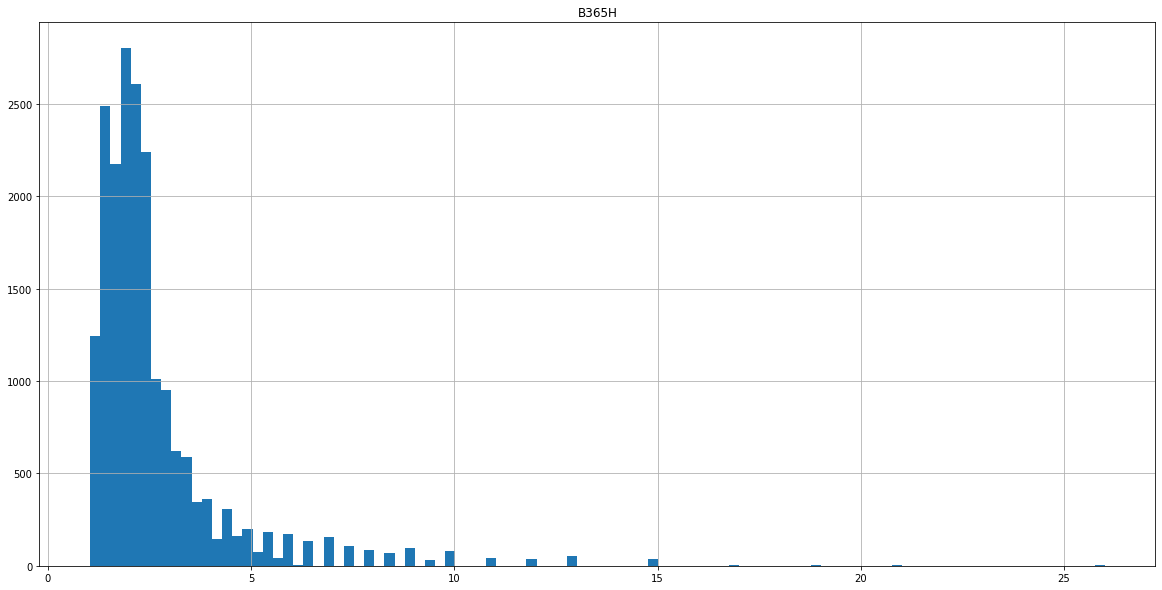

In [5]:
matches.hist(column='B365H', bins = 100,figsize=(20,10))

print("O valor mais baixo é: " + str(matches["B365H"].min()))
print("O valor mais alto é: " + str(matches["B365H"].max()))
print("O valor médio é: " + str(matches["B365H"].mean()))

plt.show()

Análise das odds de empate:

O valor mais baixo é: 1.4
O valor mais alto é: 17.0
O valor médio é: 3.8561027880757703


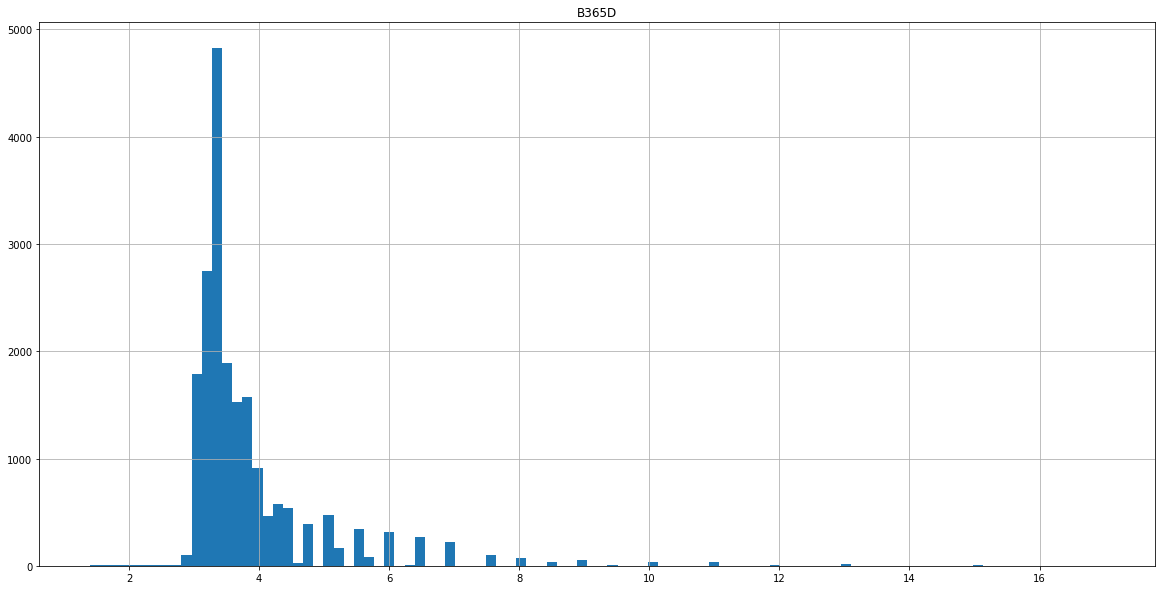

In [6]:
matches.hist(column='B365D', bins = 100,figsize=(20,10))

print("O valor mais baixo é: " + str(matches["B365D"].min()))
print("O valor mais alto é: " + str(matches["B365D"].max()))
print("O valor médio é: " + str(matches["B365D"].mean()))

plt.show()

Análise das odds da equipa visitante:

O valor mais baixo é: 1.08
O valor mais alto é: 51.0
O valor médio é: 4.6717068711594125


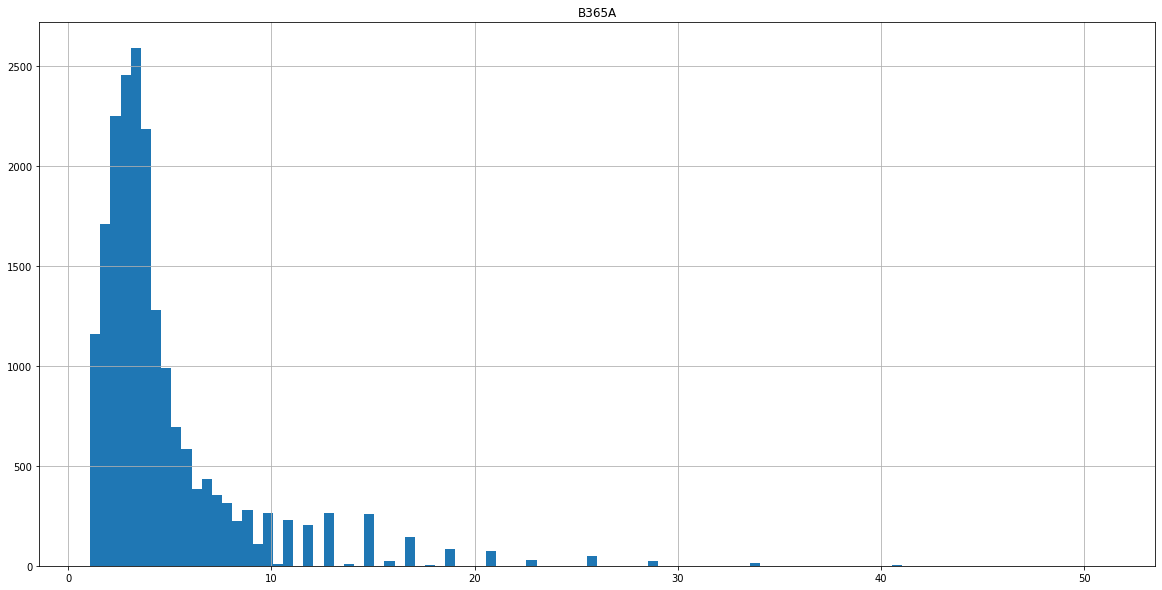

In [7]:
matches.hist(column='B365A', bins = 100,figsize=(20,10))

print("O valor mais baixo é: " + str(matches["B365A"].min()))
print("O valor mais alto é: " + str(matches["B365A"].max()))
print("O valor médio é: " + str(matches["B365A"].mean()))

plt.show()

### Informação dos jogadores
Depois criamos um dataframe com a tabela Player_Attributes, que contém informações sobre os jogadores.

In [8]:
# Get players from database
players = get_table_as_pd_dataframe('Player_Attributes')

players

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183974,102359,39902,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,77.0,59.0,89.0,77.0,84.0,86.0,78.0,84.0,85.0,66.0,72.0,77.0,86.0,73.0,76.0,58.0,72.0,67.0,81.0,56.0,78.0,86.0,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,183975,102359,39902,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,76.0,53.0,84.0,77.0,85.0,86.0,74.0,73.0,86.0,66.0,67.0,77.0,74.0,73.0,75.0,58.0,66.0,65.0,73.0,61.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,183976,102359,39902,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,71.0,53.0,84.0,77.0,85.0,86.0,74.0,73.0,86.0,66.0,67.0,77.0,74.0,73.0,75.0,58.0,66.0,65.0,73.0,67.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,183977,102359,39902,2007-08-30 00:00:00,78.0,81.0,right,medium,low,74.0,64.0,57.0,86.0,77.0,87.0,86.0,73.0,73.0,91.0,61.0,60.0,77.0,69.0,73.0,72.0,58.0,67.0,59.0,78.0,63.0,63.0,68.0,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


Também para este dataframe escolhemos as coluna essenciais, retiramos as linhas com valores nulos e ordenamos por data e rating.

In [9]:
# Set dataframe with only the important columns
players = players[["id",
                    "player_api_id",
                    "date",
                    "overall_rating"]]

# Drop rows with null values
players = players.dropna()

# Sort by date and rating
players = players.sort_values(by=['date', 'overall_rating'])

players

,id,player_api_id,date,overall_rating
57834,57835,41841,2007-02-22 00:00:00,33.0
76552,76553,127644,2007-02-22 00:00:00,35.0
132235,132236,41496,2007-02-22 00:00:00,35.0
65309,65310,35523,2007-02-22 00:00:00,36.0
131650,131651,47341,2007-02-22 00:00:00,36.0
...,...,...,...,...
153508,153509,45400,2016-07-07 00:00:00,68.0
1329,1330,495841,2016-07-07 00:00:00,72.0
19675,19676,210065,2016-07-07 00:00:00,72.0
57229,57230,184521,2016-07-07 00:00:00,73.0


Análise dos overall_ratings dos jogadores:

O overall rating mais baixo é: 33.0
O overall rating mais alto é: 94.0
O overall rating médio é: 68.6000152886831


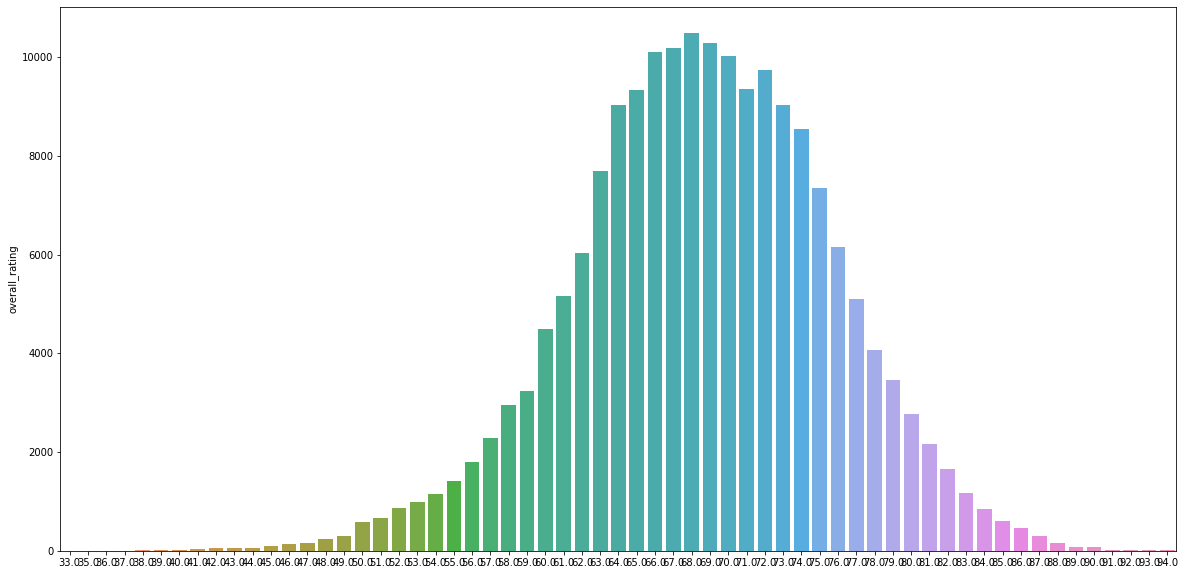

In [10]:
print("O overall rating mais baixo é: " + str(players["overall_rating"].min()))
print("O overall rating mais alto é: " + str(players["overall_rating"].max()))
print("O overall rating médio é: " + str(players["overall_rating"].mean()))

plt.figure(figsize=(20,10))
rating_series = players.overall_rating.value_counts()
sb.barplot(x=rating_series.index, y=rating_series)

### Dataframe da época 2008/2009

Para a criação de um dataframe com todos os pontos que referimos anteriormente, decidimos dividir os dataframes com a informação de jogos e de jogadores por épocas e criar funções que calculam e recolhem dados apenas relativos a uma dada época. Decidimos fazer desta forma pois é mais eficiente em termos de tempo para ir recolher, por exemplo, os ratings dos jogadores à data de um jogo, pois demorará menos tempo a encontrar uma data específica. Portanto, para acompanhar a criação das funções, primeiro iremos fazer um dataframe para a época de 2008/2009, pois é a primeira que temos disponível. Posteriormente, iremos iterar sobre todas as épocas de forma a ir buscar os dados de cada uma e juntar tudo num dataframe.

Começamos por recolher os dados dos jogos da época 2008/2009.

In [11]:
season_filter = (matches["season"] == "2008/2009")
matches_08_09 = matches.loc[season_filter]

matches_08_09

,id,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
4769,4770,2008/2009,2008-08-09 00:00:00,9827,7819,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,1.57,3.60,6.50
4770,4771,2008/2009,2008-08-09 00:00:00,9746,9831,1,0,41186.0,71607.0,38111.0,46447.0,103470.0,46651.0,46647.0,109590.0,46656.0,26405.0,41146.0,33617.0,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0,2.30,3.00,3.40
4773,4774,2008/2009,2008-08-09 00:00:00,9829,9847,1,0,145039.0,41097.0,26216.0,39199.0,38729.0,71603.0,26120.0,32566.0,33435.0,51371.0,40762.0,30742.0,20482.0,94043.0,26357.0,30457.0,30695.0,35499.0,32578.0,32572.0,37554.0,26312.0,2.40,3.10,3.10
4774,4775,2008/2009,2008-08-09 00:00:00,8481,8639,0,0,26233.0,111909.0,31684.0,94313.0,26245.0,25538.0,46757.0,26227.0,26238.0,38951.0,26494.0,26150.0,26107.0,26149.0,77741.0,26154.0,26291.0,26160.0,20401.0,32575.0,35407.0,26156.0,2.15,3.10,3.60
4776,4777,2008/2009,2008-08-09 00:00:00,9874,9855,1,2,26359.0,147351.0,26345.0,26328.0,41178.0,36396.0,26371.0,26370.0,26374.0,34983.0,41238.0,26190.0,41302.0,26027.0,32755.0,46709.0,31037.0,93480.0,5217.0,26285.0,33599.0,103482.0,1.91,3.20,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10567,10568,2008/2009,2009-05-31 00:00:00,8636,8524,4,3,30989.0,30460.0,22984.0,30492.0,27692.0,30905.0,30930.0,30724.0,108808.0,35724.0,30696.0,39170.0,41930.0,39210.0,41869.0,39201.0,31207.0,27671.0,42579.0,42645.0,38762.0,42696.0,1.44,4.00,8.00
10568,10569,2008/2009,2009-05-31 00:00:00,8600,8529,6,2,42422.0,109298.0,24970.0,27719.0,39357.0,25818.0,39644.0,111862.0,39232.0,39540.0,41542.0,39313.0,18923.0,103266.0,24403.0,24414.0,39222.0,39538.0,41404.0,41326.0,42091.0,39474.0,1.75,3.60,4.50
10570,10571,2008/2009,2009-05-31 00:00:00,8535,8564,0,2,24503.0,39621.0,24504.0,39729.0,24536.0,24507.0,24502.0,24453.0,92666.0,39719.0,30881.0,30720.0,34534.0,32752.0,26099.0,30870.0,30612.0,30731.0,23688.0,41044.0,26096.0,30729.0,2.50,3.10,2.88
10573,10574,2008/2009,2009-05-31 00:00:00,9875,8533,3,0,18558.0,41666.0,27668.0,39509.0,41337.0,41887.0,41309.0,41658.0,41350.0,41328.0,18925.0,41807.0,39273.0,113762.0,39721.0,24443.0,27731.0,42581.0,42003.0,39264.0,24448.0,32750.0,1.62,3.75,5.50


De seguida, fazemos o mesmo para os dados dos jogadores.

In [12]:
# Get first and last date of the season
first_date = matches_08_09["date"].min()
last_date = matches_08_09["date"].max()

# Get player data between those dates
date_filter = ((players["date"] >= first_date) & (players["date"] <= last_date))

players_08_09 = players.loc[date_filter]

players_08_09

,id,player_api_id,date,overall_rating
76551,76552,127644,2008-08-30 00:00:00,35.0
35002,35003,35828,2008-08-30 00:00:00,38.0
107272,107273,118822,2008-08-30 00:00:00,39.0
131648,131649,47341,2008-08-30 00:00:00,39.0
181427,181428,168342,2008-08-30 00:00:00,39.0
...,...,...,...,...
183688,183689,35724,2009-02-22 00:00:00,89.0
33351,33352,30893,2009-02-22 00:00:00,90.0
63872,63873,30717,2009-02-22 00:00:00,90.0
102504,102505,30981,2009-02-22 00:00:00,90.0


Começamos a construir o dataframe para a época 2008/2009 com os valores de id e home_team_api_id da tabela de jogos referentes a esta época.

In [13]:
id_dictionary = {
    "id": [],
    "home_team_api_id": []
}

for index, row in matches_08_09.iterrows():
    match_id = row["id"]
    home_team_id = row["home_team_api_id"]
    
    id_dictionary["id"].append(match_id)
    id_dictionary["home_team_api_id"].append(home_team_id)
        
df_08_09 = pd.DataFrame(data = id_dictionary)

df_08_09

,id,home_team_api_id
0,4770,9827
1,4771,9746
2,4774,9829
3,4775,8481
4,4777,9874
...,...,...
1721,10568,8636
1722,10569,8600
1723,10571,8535
1724,10574,9875


De seguida vamos adicionar os ratings das equipas que jogam em casa ao dataframe. Para isso criamos duas funções para conseguir calcular o rating médio do 11 inicial

In [14]:
# Get player rating from season_players dataframe, and given the match date
def get_player_rating(date, player, season_players):
    player_filter = (season_players["player_api_id"] == player)
    date_filter = (season_players["date"] <= date)
    filt = (player_filter & date_filter)
    player_info = season_players.loc[filt]
    
    # If last rating is not from this season
    if (player_info.empty):
        player_filter = (players["player_api_id"] == player)
        date_filter = (players["date"] <= date)
        filt = (player_filter & date_filter)
        player_info = players.loc[filt]
    
    # Closest date to the match
    closest_date = player_info.loc[:, "date"].max()
    
    # Get rating
    date_filter = (player_info["date"] == closest_date)
    rating = player_info.loc[date_filter, "overall_rating"].item()
    return rating
  
    
# Get team rating from match of season_matches
def get_team_rating(condition, index, season_matches, season_players):
    date = season_matches.loc[index, "date"]
    
    team_rating = 0
    
    # Add all the player ratings
    for player_num in range(1, 12):
        column = condition + "_player_" + str(player_num)
        player = season_matches.loc[index, column]
        player_rating = get_player_rating(date, player, season_players)
        team_rating = team_rating + player_rating
    
    # Do the average
    team_rating = team_rating/11.0
    return team_rating


rating_dictionary = {
    "home_team_rating": []
}

for index, row in matches_08_09.iterrows():
    home_team_rating = get_team_rating("home", index, matches_08_09, players_08_09)
    
    rating_dictionary["home_team_rating"].append(home_team_rating)
        
rating_df = pd.DataFrame(data = rating_dictionary)
df_08_09 = df_08_09.join(rating_df)

df_08_09

,id,home_team_api_id,home_team_rating
0,4770,9827,74.454545
1,4771,9746,64.909091
2,4774,9829,67.909091
3,4775,8481,69.818182
4,4777,9874,69.545455
...,...,...,...
1721,10568,8636,83.636364
1722,10569,8600,77.181818
1723,10571,8535,79.727273
1724,10574,9875,74.818182


Depois vamos adicionar a forma da equipa da casa. A forma é calculada através da média de pontos ganhos nos ultimos 5 jogos. Foram criadas duas funções para efetuar esse calculo.

In [15]:
# Get points earned by team on a given match
def get_result(team_id, team_filter, date, season_matches):
    # Get match, given date
    date_filter = (season_matches["date"] == date)
    filt = (team_filter & date_filter)
    match = season_matches.loc[filt]
    
    # Get goals scored
    home_goals = match["home_team_goal"].item()
    away_goals = match["away_team_goal"].item()
    
    if match["home_team_api_id"].item() == team_id:
        if home_goals > away_goals:
            return 3
        elif home_goals < away_goals:
            return 0
        else:
            return 1
    else:
        if away_goals > home_goals:
            return 3
        elif away_goals < home_goals:
            return 0
        else:
            return 1

        
# Get form of the team, wich is a value from 0 to 3
def get_form(team_id, team_filter, date, season_matches):
    # Get last matches
    date_filter = (season_matches["date"] < date)
    filt = (team_filter & date_filter)
    last_matches = season_matches.loc[filt]
    
    # Get last 5
    last_5_matches = last_matches.tail(5)
    
    if (last_5_matches.empty):
        return 0
    
    form = 0
    
    # Add total points
    for index, row in last_5_matches.iterrows():
        match_date = row["date"]
        result = get_result(team_id, team_filter, match_date, season_matches)
        form = form + result
    
    # Average number of points
    index = last_5_matches.index
    num_matches = len(index)
    form = form / num_matches
    
    return form

form_dictionary = {
    "home_team_form": []
}

for index, row in matches_08_09.iterrows():
    team_id = row["home_team_api_id"]
    date = row["date"]
    team_filter = ((matches_08_09["home_team_api_id"] == team_id) | (matches_08_09["away_team_api_id"] == team_id))
    home_team_form = get_form(team_id, team_filter, date, matches_08_09)
    
    form_dictionary["home_team_form"].append(home_team_form)
        
form_df = pd.DataFrame(data = form_dictionary)
df_08_09 = df_08_09.join(form_df)

df_08_09

,id,home_team_api_id,home_team_rating,home_team_form
0,4770,9827,74.454545,0.0
1,4771,9746,64.909091,0.0
2,4774,9829,67.909091,0.0
3,4775,8481,69.818182,0.0
4,4777,9874,69.545455,0.0
...,...,...,...,...
1721,10568,8636,83.636364,1.2
1722,10569,8600,77.181818,2.6
1723,10571,8535,79.727273,2.0
1724,10574,9875,74.818182,0.8


Agora adicionamos a forma da equipa da casa em jogos em casa. Para calcular a forma usamos as mesmas funções definidas anteriormente.

In [16]:
home_form_dictionary = {
    "home_team_form_at_home": []
}

for index, row in matches_08_09.iterrows():
    team_id = row["home_team_api_id"]
    date = row["date"]
    team_filter = (matches_08_09["home_team_api_id"] == team_id)
    home_team_form_at_home = get_form(team_id, team_filter, date, matches_08_09)
    
    home_form_dictionary["home_team_form_at_home"].append(home_team_form_at_home)
        
home_form_df = pd.DataFrame(data = home_form_dictionary)
df_08_09 = df_08_09.join(home_form_df)

df_08_09

,id,home_team_api_id,home_team_rating,home_team_form,home_team_form_at_home
0,4770,9827,74.454545,0.0,0.0
1,4771,9746,64.909091,0.0,0.0
2,4774,9829,67.909091,0.0,0.0
3,4775,8481,69.818182,0.0,0.0
4,4777,9874,69.545455,0.0,0.0
...,...,...,...,...,...
1721,10568,8636,83.636364,1.2,2.2
1722,10569,8600,77.181818,2.6,2.0
1723,10571,8535,79.727273,2.0,2.4
1724,10574,9875,74.818182,0.8,1.0


Para finalizar o dataframe relativo à época de 2008/2009, utilizamos as funções definidas anteriormente para adicionar os dados relativos à equipa visitante.

In [17]:
away_dictionary = {
    "away_team_api_id": [],
    "away_team_rating": [],
    "away_team_form": [],
    "away_team_form_away": []
}

for index, row in matches_08_09.iterrows():
    away_team_id = row["away_team_api_id"]
    
    away_team_rating = get_team_rating("away", index, matches_08_09, players_08_09)
    
    date = row["date"]
    
    team_filter = ((matches_08_09["home_team_api_id"] == away_team_id) | (matches_08_09["away_team_api_id"] == away_team_id))
    away_team_form = get_form(away_team_id, team_filter, date, matches_08_09)
    
    team_filter = (matches_08_09["away_team_api_id"] == away_team_id)
    away_team_form_away = get_form(away_team_id, team_filter, date, matches_08_09)
    
    away_dictionary["away_team_api_id"].append(away_team_id)
    away_dictionary["away_team_rating"].append(away_team_rating)
    away_dictionary["away_team_form"].append(away_team_form)
    away_dictionary["away_team_form_away"].append(away_team_form_away)
    
away_df = pd.DataFrame(data = away_dictionary)
df_08_09 = df_08_09.join(away_df)

df_08_09

,id,home_team_api_id,home_team_rating,home_team_form,home_team_form_at_home,away_team_api_id,away_team_rating,away_team_form,away_team_form_away
0,4770,9827,74.454545,0.0,0.0,7819,69.454545,0.0,0.0
1,4771,9746,64.909091,0.0,0.0,9831,68.818182,0.0,0.0
2,4774,9829,67.909091,0.0,0.0,9847,73.363636,0.0,0.0
3,4775,8481,69.818182,0.0,0.0,8639,72.454545,0.0,0.0
4,4777,9874,69.545455,0.0,0.0,9855,65.090909,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1721,10568,8636,83.636364,1.2,2.2,8524,73.000000,1.0,1.2
1722,10569,8600,77.181818,2.6,2.0,8529,72.090909,1.0,1.0
1723,10571,8535,79.727273,2.0,2.4,8564,80.909091,1.4,2.0
1724,10574,9875,74.818182,0.8,1.0,8533,71.000000,0.8,1.8


### Dataframe final

Tendo criado todas as funções necessárias para a recolha de dados e a criação de um dataframe relativo a uma época, o próximo passo será criar um dataframe relativo a todas as épocas, iterando estas funções para cada época fornecida pela base de dados

In [18]:
# Get season name
def get_season(year):
    year2 = year + 1
    years = str(year)
    year2s = str(year2)
        
    season = years + "/" + year2s
    
    return season


dictionary = {
        "id": [],
        "home_team_api_id": [],
        "home_team_rating": [],
        "home_team_form": [],
        "home_team_form_at_home": [],
        "away_team_api_id": [],
        "away_team_rating": [],
        "away_team_form": [],
        "away_team_form_away": [],
        "B365H": [],
        "B365D": [],
        "B365A": []
    }

year = 2008

# While there are remaining seasons
while 1:
    season = get_season(year)
    season_filter = (matches["season"] == season)
    season_matches = matches.loc[season_filter]
    
    # If season is empty break
    if season_matches.empty:
        break;
    
    first_date = season_matches.loc[:, "date"].min()
    last_date = season_matches.loc[:, "date"].max()
    date_filter = ((players["date"] >= first_date) & (players["date"] <= last_date))
    season_players = players.loc[date_filter]
     
    for index, row in season_matches.iterrows():
        match_id = row["id"]
        
        home_team_id = row["home_team_api_id"]
        
        home_team_rating = get_team_rating("home", index, season_matches, season_players)
        
        date = row["date"]
        team_filter = ((season_matches["home_team_api_id"] == home_team_id) | (season_matches["away_team_api_id"] == home_team_id))
        home_team_form = get_form(home_team_id, team_filter, date, season_matches)
        
        team_filter = (season_matches["home_team_api_id"] == home_team_id)
        home_team_form_at_home = get_form(home_team_id, team_filter, date, season_matches)
        
        away_team_id = row["away_team_api_id"]
    
        away_team_rating = get_team_rating("away", index, season_matches, season_players)
        
        team_filter = ((season_matches["home_team_api_id"] == away_team_id) | (season_matches["away_team_api_id"] == away_team_id))
        away_team_form = get_form(away_team_id, team_filter, date, season_matches)
        
        team_filter = (season_matches["away_team_api_id"] == away_team_id)
        away_team_form_away = get_form(away_team_id, team_filter, date, season_matches)
        
        b365h = row["B365H"]
        b365d = row["B365D"]
        b365a = row["B365A"]
        
        dictionary["id"].append(match_id)
        dictionary["home_team_api_id"].append(home_team_id)
        dictionary["home_team_rating"].append(home_team_rating)
        dictionary["home_team_form"].append(home_team_form)
        dictionary["home_team_form_at_home"].append(home_team_form_at_home)
        dictionary["away_team_api_id"].append(away_team_id)
        dictionary["away_team_rating"].append(away_team_rating)
        dictionary["away_team_form"].append(away_team_form)
        dictionary["away_team_form_away"].append(away_team_form_away)
        dictionary["B365H"].append(b365h)
        dictionary["B365D"].append(b365d)
        dictionary["B365A"].append(b365a)
        
    year = year + 1
        
df = pd.DataFrame(data = dictionary)

df

,id,home_team_api_id,home_team_rating,home_team_form,home_team_form_at_home,away_team_api_id,away_team_rating,away_team_form,away_team_form_away,B365H,B365D,B365A
0,4770,9827,74.454545,0.0,0.0,7819,69.454545,0.0,0.0,1.57,3.60,6.50
1,4771,9746,64.909091,0.0,0.0,9831,68.818182,0.0,0.0,2.30,3.00,3.40
2,4774,9829,67.909091,0.0,0.0,9847,73.363636,0.0,0.0,2.40,3.10,3.10
3,4775,8481,69.818182,0.0,0.0,8639,72.454545,0.0,0.0,2.15,3.10,3.60
4,4777,9874,69.545455,0.0,0.0,9855,65.090909,0.0,0.0,1.91,3.20,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...
19686,24491,8603,75.727273,1.0,1.8,8305,74.636364,1.0,0.6,5.00,3.80,1.70
19687,24492,8558,74.363636,0.8,2.0,8372,73.090909,1.0,0.4,2.00,3.60,3.70
19688,24495,9864,75.545455,0.8,1.6,8306,71.363636,1.0,1.8,1.80,3.75,4.50
19689,24497,8370,72.909091,0.8,1.4,8581,73.272727,1.4,0.2,1.33,5.25,9.00


## 4. Avaliação Experimental

Com a ajuda de algumas ferramentas, como o Jupyter, Scikit-learn, NumPy e Pandas, foram implementados quatro algoritmos:
+ Árvore de decisão
+ Redes neuronais
+ K-Nearest Neighbor
+ Support Vector Machines

Posteriormente, comparamos o desempenho destes algoritmos, tendo em conta os erros obtidos no processo de aprendizagem, a qualidade de previsão e o tempo necessário para a realização do treino e do teste.
Além disso, comparamos também os resultados obtidos pelos diferentes algoritmos, através de tabelas e gráficos. Para isso, usamos duas bibliotecas de visualização de dados, o Seaborn e o Matplotlib.

Começamos por dividir os dados em dois conjuntos: o conjunto de treino e o conjunto de teste. Iremos usar 80% dos dados para o treino e os restantes 20% para o teste.

In [19]:
#split data into training and test

test_df = df.drop(["home_team_api_id", "away_team_api_id"], axis=1)

odds_df = matches.loc[:, ["B365H", "B365D", "B365A"]]

matches_train, matches_test, odds_train, odds_test = train_test_split(test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, test_size=0.20)

CPU times: user 7.85 ms, sys: 0 ns, total: 7.85 ms
Wall time: 6.49 ms


### Árvores de Decisão

Primeiro vamos analisar as Árvores de Decisão.

Iremos experimentar vários parâmetros, de forma a descobrir quais os melhores a utilizar.

In [87]:
start_time = time.time()

pipe_tree = Pipeline([("scl", StandardScaler()),
("reg", MultiOutputRegressor(DecisionTreeRegressor()))])

# Lista de parametros e respetivos valores possíveis
decision_tree_param_grid = {
    'reg__estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'reg__estimator__max_features': [1, 2, 3, 4, 5, 6]
}

gs_tree = (GridSearchCV(estimator=pipe_tree,
                        param_grid=decision_tree_param_grid,
                        n_jobs = -1))

gs_tree = gs_tree.fit(matches_train, odds_train)

end_time = time.time()
tree_time = end_time - start_time

decision_tree_regressor = gs_tree.best_estimator_

decision_tree_regressor

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=7,
                                                                      max_features=5,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                                                      min_samples_leaf=1,
                                                                      min_samples_split=2,
                                                 

Tendo em conta o resultado obtido, verificamos que o melhor modelo é atingido com max_depth igual a 7 e max_features igual a 6. Iremos analisar agora as odds previstas.

In [48]:
# First we create a dataframe with the real odds
real_predicted_odds = odds_test

tree_odds = decision_tree_regressor.predict(matches_test)

tree_odds = pd.DataFrame({'Tree B365H': tree_odds[:, 0], 'Tree B365D': tree_odds[:, 1], 'Tree B365A': tree_odds[:, 2]})
real_predicted_odds = real_predicted_odds.join(tree_odds, how='inner')

real_predicted_odds

,B365H,B365D,B365A,Tree B365H,Tree B365D,Tree B365A
1960,5.00,3.60,1.72,3.303495,3.425216,2.518043
3919,7.50,5.00,1.44,4.153548,3.425216,3.165429
1696,1.75,3.50,4.75,2.169660,3.456704,4.196772
2016,2.10,3.25,3.75,2.388853,3.425216,4.429691
3508,1.25,6.50,14.00,1.310547,4.957660,11.145833
...,...,...,...,...,...,...
1901,1.72,3.40,5.50,2.169660,3.456704,3.165429
954,3.30,3.30,2.20,2.169660,3.456704,3.165429
3834,5.50,3.80,1.73,2.745178,4.434627,2.760896
3320,2.00,3.50,3.75,2.891040,3.425216,2.089726


De seguida iremos realizar 10 fold cross validation de forma a avaliar o modelo. Apenas usamos métricas suportadas por multioutput. 

In [95]:
# R2, wich is the proportion of the variance in the dependent variable that is predictable from the independent variables
scores = cross_val_score(decision_tree_regressor, test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, scoring="r2", cv=10)
r2 = scores.mean()

# Neg mean absolute error
scores = cross_val_score(decision_tree_regressor, test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, scoring="neg_mean_absolute_error", cv=10)
error = scores.mean()

# Create dataframe with metrics
columns = ['Algorithm', 'Train time', 'r2','Neg mean absolute error']
metrics = pd.DataFrame(columns=columns)
metrics.loc[0] = ["Decision tree", tree_time, r2, error]

metrics

,Algorithm,time,r2,Neg mean absolute error
0,Decision tree,14.549524,0.600459,-0.737094


### Neural Networks

De seguida vamos analisar o modelo neural networks.

Iremos experimentar vários parâmetros, de forma a descobrir quais os melhores a utilizar.

In [99]:
start_time = time.time()

nn_parameter_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

nn_search = GridSearchCV(MLPRegressor(max_iter=1000, random_state=1), nn_parameter_grid, n_jobs = -1)

nn_search.fit(matches_train, odds_train)

end_time = time.time()
nn_time = end_time - start_time

neural_network = nn_search.best_estimator_

neural_network

MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

Podemos verificar que o melhor modelo é atingido com activation igual a 'rulu', alpha igual a 0.05, hidden_layer_sizes igual a (50, 100, 50) e, finalmente, learning_rate igual 'constant'. Iremos analisar agora as odds previstas.

In [96]:
nn_odds = neural_network.predict(matches_test)

nn_odds = pd.DataFrame({'NN B365H': nn_odds[:, 0], 'NN B365D': nn_odds[:, 1], 'NN B365A': nn_odds[:, 2]})
real_predicted_odds = real_predicted_odds.join(nn_odds, how='inner')

real_predicted_odds

ValueError: columns overlap but no suffix specified: Index(['NN B365H', 'NN B365D', 'NN B365A'], dtype='object')

Realizamos mais uma vez 10 fold cross validation de forma a avaliar o modelo.

In [112]:
# R2, wich is the proportion of the variance in the dependent variable that is predictable from the independent variables
scores = cross_val_score(neural_network, test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, scoring="r2", cv=10)
r2 = scores.mean()

# Neg mean absolute error
scores = cross_val_score(neural_network, test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, scoring="neg_mean_absolute_error", cv=10)
error = scores.mean()

# Add metrics
metrics.loc[1] = ["Neural Network", nn_time, r2, error]

metrics

,Algorithm,time,r2,Neg mean absolute error
0,Decision tree,14.549524,0.600459,-0.737094
1,Neural Network,206.305032,0.640127,-0.690324
2,K-Nearest Neighbors,126.948400,0.681014,-0.655204


Existe uma clara diferença no que toca ao tempo para estes dois algoritmos. Por outro lado, o neural networks apresenta um valor de r2 consideralmente superior e um melhor resultado também no que toca aos erros.

### K-Nearest Neighbors

Agora iremos analisar o modelo k-nearest neighbors.

Iremos experimentar vários parâmetros, de forma a descobrir quais os melhores a utilizar.

In [103]:
start_time = time.time()

kn_pipe = Pipeline([("scl", StandardScaler()),
    ("reg", MultiOutputRegressor(KNeighborsRegressor(n_jobs=-1)))])

knearest_param_grid = {
    'reg__estimator__n_neighbors': [1, 3, 5, 7, 9],
    'reg__estimator__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'reg__estimator__weights': ['uniform', 'distance']
}

kn_search = GridSearchCV(
    kn_pipe,
    knearest_param_grid,
    n_jobs = -1
)

kn_search = kn_search.fit(matches_train, odds_train)

end_time = time.time()
knn_time = end_time - start_time

knn = kn_search.best_estimator_

knn

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='brute',
                                                                    leaf_size=30,
                                                                    metric='minkowski',
                                                                    metric_params=None,
                                                                    n_jobs=-1,
                                                                    n_neighbors=9,
                                                                    p=2,
                                                                    weights='distance'),
                                      n_jobs=None))],
         verbose=False)

Concluimos que o melhor modelo se obtém com n_neighbors igual a 9, algorithm igual a 'brute' e weights igual a 'distance'. Analisamos agora as odds previstas.

In [132]:
knn_odds = knn.predict(matches_test)

knn_odds = pd.DataFrame({'KNN B365H': knn_odds[:, 0], 'KNN B365D': knn_odds[:, 1], 'KNN B365A': knn_odds[:, 2]})
real_predicted_odds = real_predicted_odds.join(knn_odds, how='inner')

real_predicted_odds

,B365H,B365D,B365A,Tree B365H,Tree B365D,Tree B365A,NN B365H,NN B365D,NN B365A,SVM B365H,SVM B365D,SVM B365A,KNN B365H,KNN B365D,KNN B365A
1960,5.00,3.60,1.72,3.303495,3.425216,2.518043,3.238533,3.618159,2.773248,2.862828,3.276827,2.681747,2.924596,3.122801,2.610827
3919,7.50,5.00,1.44,4.153548,3.425216,3.165429,2.916345,3.242074,2.539267,3.230427,3.376706,2.268873,3.335074,3.378772,2.263307
1696,1.75,3.50,4.75,2.169660,3.456704,4.196772,1.764217,3.344800,4.274944,1.915412,3.447678,4.037247,2.159169,3.485056,3.760903
2016,2.10,3.25,3.75,2.388853,3.425216,4.429691,2.118722,3.531743,4.016673,2.105825,3.296994,3.582153,2.217252,3.432908,3.673897
3508,1.25,6.50,14.00,1.310547,4.957660,11.145833,1.387850,6.148891,13.181880,1.259550,5.857505,12.917464,1.272857,5.569891,13.165360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,1.72,3.40,5.50,2.169660,3.456704,3.165429,2.807574,3.195119,2.576132,2.958959,3.428594,2.344102,2.655751,3.361644,2.821458
954,3.30,3.30,2.20,2.169660,3.456704,3.165429,1.810396,3.023326,3.685142,2.275779,3.351090,3.002155,2.280385,3.371439,3.185361
3834,5.50,3.80,1.73,2.745178,4.434627,2.760896,3.060189,3.285945,2.420959,3.392650,3.451293,2.204944,3.442122,3.535484,2.087422
3320,2.00,3.50,3.75,2.891040,3.425216,2.089726,4.402270,3.722161,2.554428,3.751694,3.324061,2.107138,4.420690,3.478085,2.075090


Com o 10 fold cross validation de forma avaliamos o modelo.

In [111]:
# R2, wich is the proportion of the variance in the dependent variable that is predictable from the independent variables
scores = cross_val_score(knn, test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, scoring="r2", cv=10)
r2 = scores.mean()

# Neg mean absolute error
scores = cross_val_score(knn, test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, scoring="neg_mean_absolute_error", cv=10)
error = scores.mean()

# Add metrics
metrics.loc[2] = ["K-Nearest Neighbors", knn_time, r2, error]

metrics

,Algorithm,time,r2,Neg mean absolute error
0,Decision tree,14.549524,0.600459,-0.737094
1,Neural Network,206.305032,0.610395,-0.739093
2,K-Nearest Neighbors,126.948400,0.681014,-0.655204


Verificamos que o tempo de treino está entre os dois algoritmos analisados anteriormente. Os valores de r2 e neg mean absolute error são melhores que os dos outros dois algoritmos

### Support vector machines

Por fim vamos analisar o modelo support vector machines.

Iremos experimentar vários parâmetros, de forma a descobrir quais os melhores a utilizar.

In [113]:
start_time = time.time()

svm_net = Pipeline([("scl", StandardScaler()),
    ("reg", MultiOutputRegressor(SVR()))])

svm_param_grid = {
    'reg__estimator__degree': [2,3,4],
    'reg__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

gs_svr = (GridSearchCV(estimator=svm_net,
                        param_grid=svm_param_grid,
                        n_jobs = -1))

gs_svr = gs_svr.fit(matches_train, odds_train)

end_time = time.time()
svm_time = end_time - start_time

svm = gs_svr.best_estimator_

svm

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200,
                                                    coef0=0.0, degree=2,
                                                    epsilon=0.1, gamma='scale',
                                                    kernel='rbf', max_iter=-1,
                                                    shrinking=True, tol=0.001,
                                                    verbose=False),
                                      n_jobs=None))],
         verbose=False)

Podemos verificar conseguimos alcançar o melhor modelo quando usamos degree igual a 2 e kernel igual a 'rbf'. Analisamos agora as odds previstas.

In [115]:
svm_odds = svm.predict(matches_test)

svm_odds = pd.DataFrame({'SVM B365H': svm_odds[:, 0], 'SVM B365D': svm_odds[:, 1], 'SVM B365A': svm_odds[:, 2]})
real_predicted_odds = real_predicted_odds.join(svm_odds, how='inner')

real_predicted_odds

,B365H,B365D,B365A,Tree B365H,Tree B365D,Tree B365A,NN B365H,NN B365D,NN B365A,SVM B365H,SVM B365D,SVM B365A
1960,5.00,3.60,1.72,3.303495,3.425216,2.518043,3.238533,3.618159,2.773248,2.862828,3.276827,2.681747
3919,7.50,5.00,1.44,4.153548,3.425216,3.165429,2.916345,3.242074,2.539267,3.230427,3.376706,2.268873
1696,1.75,3.50,4.75,2.169660,3.456704,4.196772,1.764217,3.344800,4.274944,1.915412,3.447678,4.037247
2016,2.10,3.25,3.75,2.388853,3.425216,4.429691,2.118722,3.531743,4.016673,2.105825,3.296994,3.582153
3508,1.25,6.50,14.00,1.310547,4.957660,11.145833,1.387850,6.148891,13.181880,1.259550,5.857505,12.917464
...,...,...,...,...,...,...,...,...,...,...,...,...
1901,1.72,3.40,5.50,2.169660,3.456704,3.165429,2.807574,3.195119,2.576132,2.958959,3.428594,2.344102
954,3.30,3.30,2.20,2.169660,3.456704,3.165429,1.810396,3.023326,3.685142,2.275779,3.351090,3.002155
3834,5.50,3.80,1.73,2.745178,4.434627,2.760896,3.060189,3.285945,2.420959,3.392650,3.451293,2.204944
3320,2.00,3.50,3.75,2.891040,3.425216,2.089726,4.402270,3.722161,2.554428,3.751694,3.324061,2.107138


Visto que o 10 fold cross validation demorava demasiado tempo, usamos apenas o tempo de treino e r2 para avaliar o modelo

In [129]:
# R2, wich is the proportion of the variance in the dependent variable that is predictable from the independent variables
r2 = svm.score(matches_test, odds_test)

# Add metrics
metrics.loc[3] = ["Support Vector Machines", svm_time, r2, 0]

metrics

,Algorithm,time,r2,Neg mean absolute error
0,Decision tree,14.549524,0.600459,-0.737094
1,Neural Network,206.305032,0.640127,-0.690324
2,K-Nearest Neighbors,126.948400,0.681014,-0.655204
3,Support Vector Machines,733.575663,0.727681,0.000000


Existe uma diferença muito grande em relação ao tempo de treino dos outros algoritmos, para apenas um ligeiro aumento do r2 em relação ao k-nearest neighbors.

Odds da equipa da casa obtidas:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0c4bf2978>,
      dtype=object)

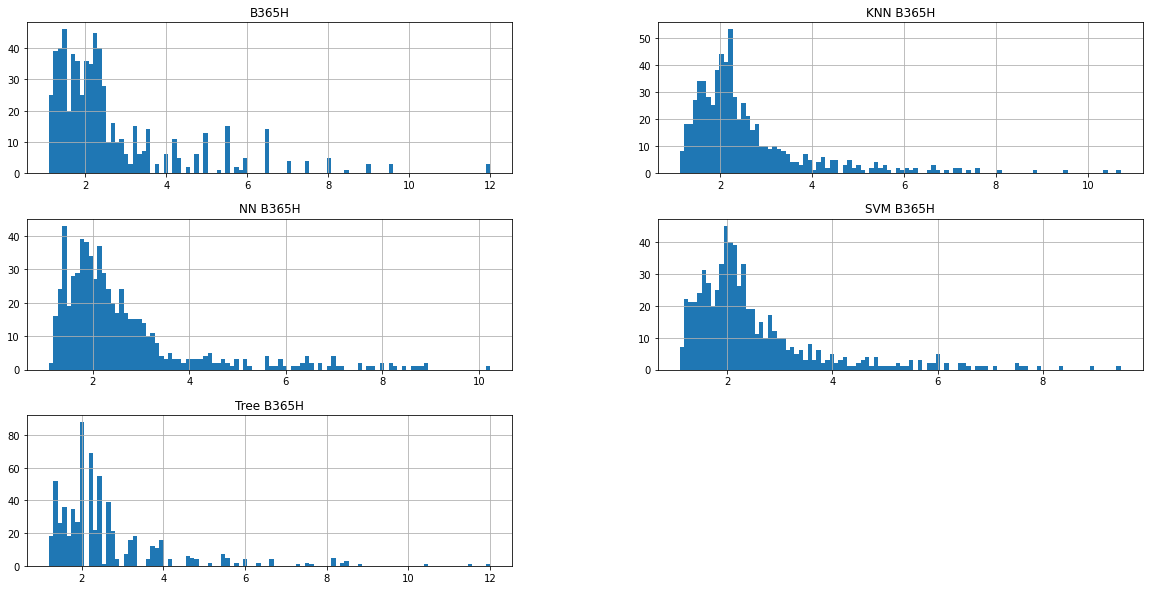

In [135]:
real_predicted_odds.hist(column=['B365H', 'Tree B365H', 'NN B365H', 'KNN B365H', 'SVM B365H'], bins = 100,figsize=(20,10))

Odds de empate obtidas:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff08e59dc50>,
      dtype=object)

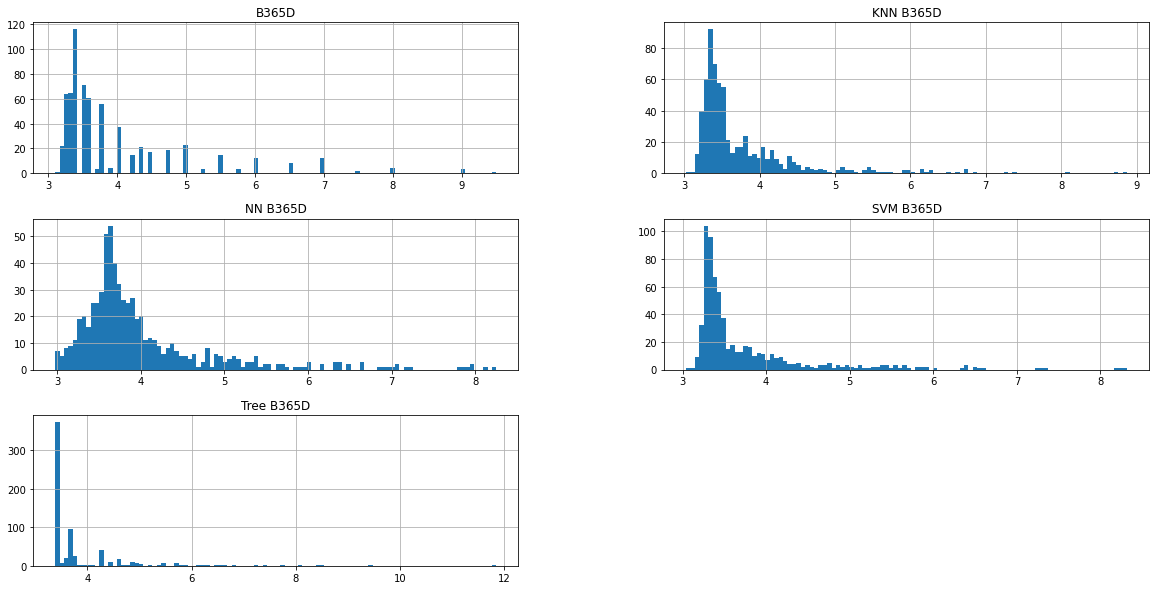

In [137]:
real_predicted_odds.hist(column=['B365D', 'Tree B365D', 'NN B365D', 'KNN B365D', 'SVM B365D'], bins = 100,figsize=(20,10))

Odds da equipa visitante obtidas:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff07bfa87b8>,
      dtype=object)

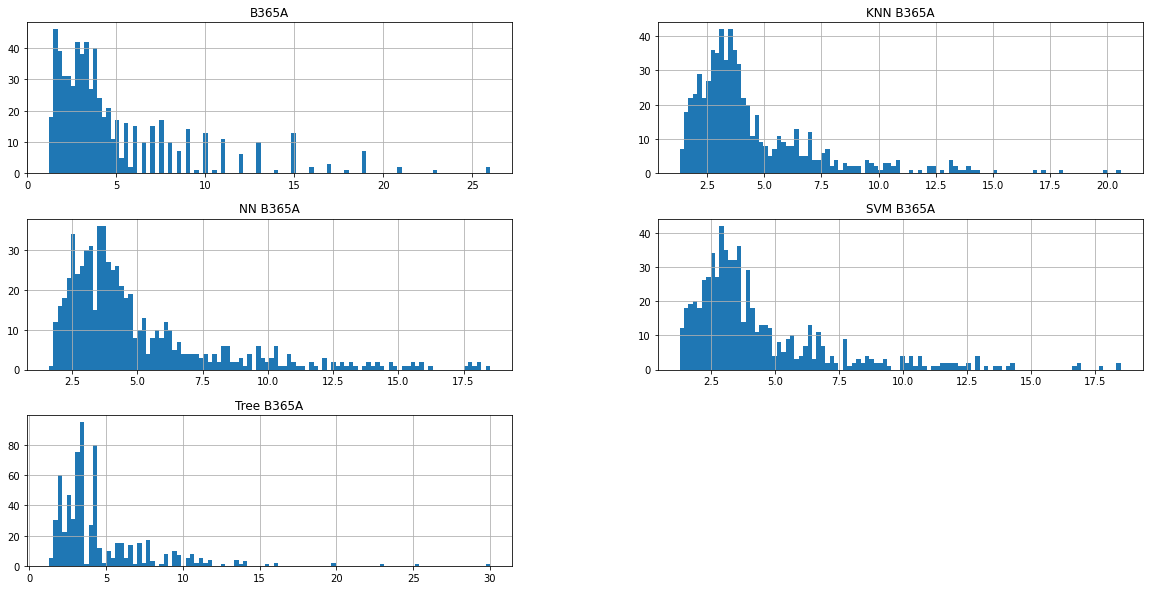

In [139]:
real_predicted_odds.hist(column=['B365A', 'Tree B365A', 'NN B365A', 'KNN B365A', 'SVM B365A'], bins = 100,figsize=(20,10))

Comparação dos tempos de treino dos algoritmos:

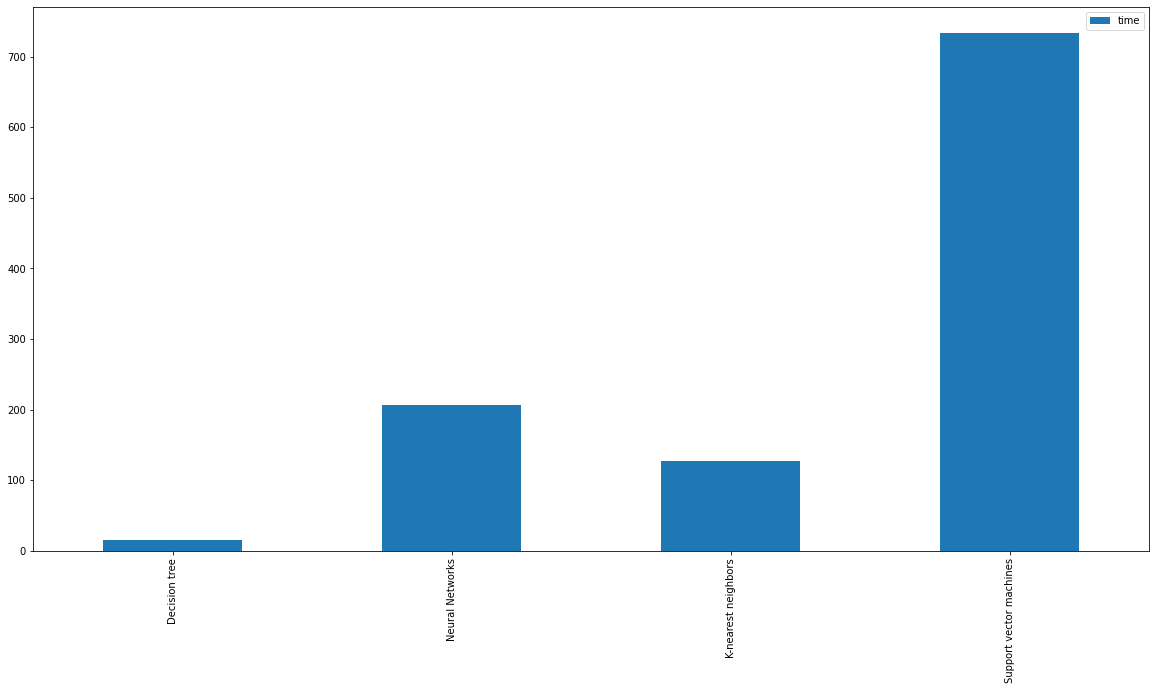

In [145]:
index = ['Decision tree', 'Neural Networks', 'K-nearest neighbors', 'Support vector machines']
metrics.index = index
metrics.plot.bar(y='time', figsize=(20,10))

Comparação do r2 dos algoritmos:

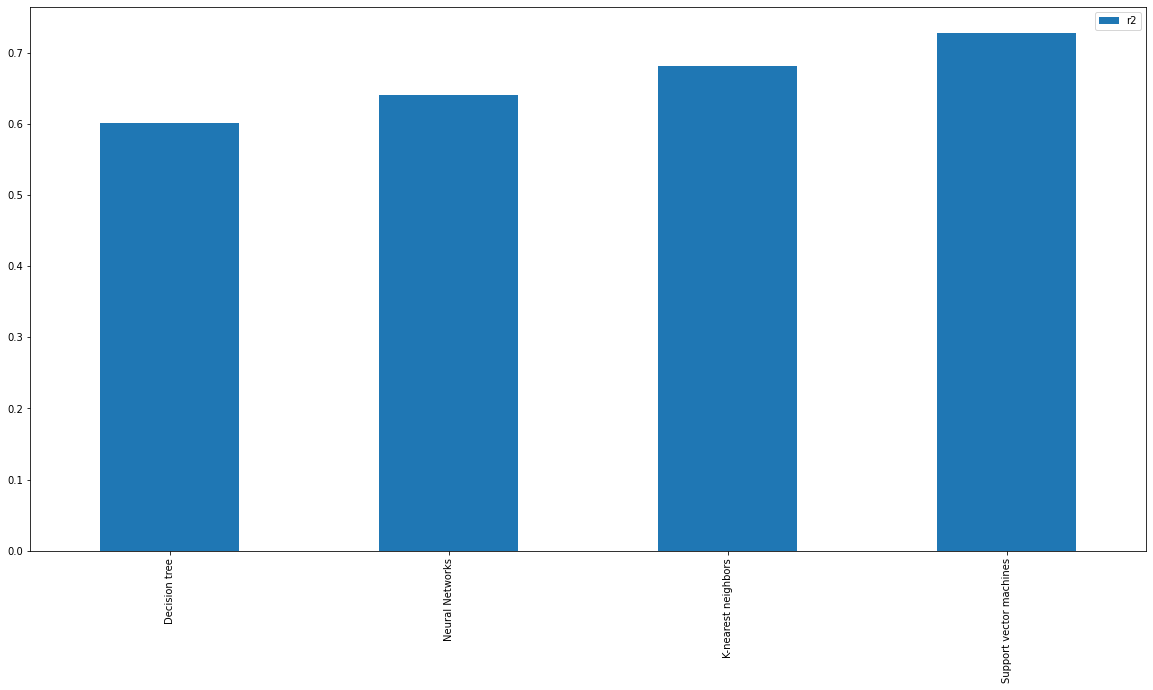

In [148]:
metrics.plot.bar(y='r2', figsize=(20,10))

Comparação do neg mean absolute error dos algoritmos:

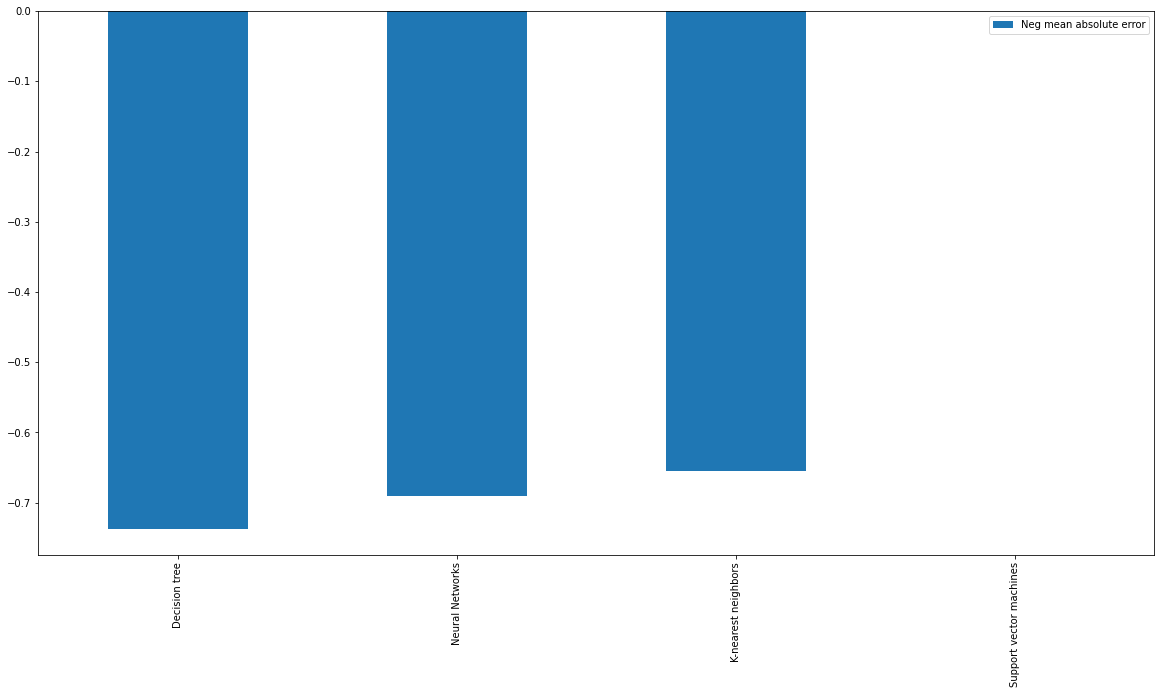

In [150]:
metrics.plot.bar(y='Neg mean absolute error', figsize=(20,10))

## 5. Conclusões

Podemos começar por concluir que todo o trabalho foi realizado com sucesso e os objetivos cumpridos.

Todos os quatro algoritmos de aprendizagem supervisionada foram explorados e avaliados e obtiveram-se resultados interessantes de regressão.

Observando as métricas e os gráficos podemos concluir que, embora utilize um tempo de treino bastante superior ao algoritmo de árvores de decisão, o support vector machines revela melhores resultados no que toca ao r2, mas nem foi possível calcular o neg mean absolute error. Se o tempo for o nosso maior foco na decisão de um algoritmo, então devemos optar pelo algoritmo de decisão de árvores. Por outro lado, se tivermos em conta todos os fatores, o k-nearest neighbors revela ser o melhor algoritmo, pois é o segundo mais eficiente em termos de tempo e obteve resultados excelentes usando 10 cross folding.

Finalmente, tendo em conta o tema abordado e as tecnologias utilizadas, o projeto revelou ser muito interessante. Todos os elementos do grupo ganharam um maior conhecimento sobre Aprendizagem Supervisionada e todas as tecnologias utilizadas.

## Referências

+ https://github.com/nanazhu/DataMining-Football-Match-Prediction
+ https://github.com/danleh/predict-euro2016
+ https://github.com/yanuehara/ai-soccer-prediction
